# 作业五：实战NLP——讽刺检测

近年来，以社交媒体为媒介的电子新闻已成为信息消费的主要来源之一。许多媒体公司正在尝试采用各种方法来增加帖子的浏览量，其中一种方法是使用讽刺标题作为用户点击的诱饵。一个能够预测一篇新闻的标题是否具有讽刺意味的模型对于媒体公司而言具有显而易见的作用，方便了季度收益的分析。此外，从读者的角度来说，搜索引擎可以利用这些讽刺的信息，并根据读者的偏好，向他们推荐类似的文章。

## 数据集
用于讽刺检测的新闻标题数据集，该数据集来自两个新闻网站，theonion.com和huffingtonpost.com。以往的研究大多使用基于标签监督收集的Twitter数据集，但这些数据集在标签和语言方面存在噪声。此外，许多tweet是对其他tweet的回复，检测其中的讽刺需要上下文tweet的信息。采用的新的数据集与现有的Twitter数据集相比有以下优点:
由于新闻标题是由专业人士以正式的方式编写的，所以没有拼写错误和非正式用法。
此外，由于本数据的唯一目的是发布讽刺的新闻，与Twitter数据集相比，标签的质量要更高，噪音小得多。与需要接受上下语境的Twitter数据集不同，本新闻标题数据集是独立于上下文的。这将有助于我们梳理出真正的讽刺元素。

## 导入相关包

In [ ]:
import wget
import os
import re
import json
import time
import nltk
import torch
import datetime
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from collections import Counter
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

## 文件夹结构搭建 & 下载训练数据和预训练模型
为模型的训练做必要的准备。完成后，文件夹结构如下：

```
├──GloVe（存储预训练词向量模型）  
├──archive（存储训练数据）
├──TrainingLog（存储训练日志）
├──Figure（存储训练结果的图片）
    
```

In [ ]:
def setup():
    # 搭建文件夹结构
    folders = ['./Figure', './TrainingLog']
    for folder in folders:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # 下载并解压预训练词向量模型
    if not os.path.exists('./GloVe/glove.6B.300d.txt'):
        wget.download('https://nlp.stanford.edu/data/glove.6B.zip', './glove.6B.zip')
        with zipfile.ZipFile('./glove.6B.zip') as zf:
            zf.extractall()
        os.rename('./glove.6B', './GloVe')
        os.remove('./glove.6B.zip')
    
    # 下载并解压训练数据
    if not os.path.exists('./archive'):
        wget.download('https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/download', './archive.zip')
        with zipfile.ZipFile('./archive.zip') as zf:
            zf.extractall()
        os.remove('./archive.zip')

setup()

 43% [..............................                                        ] 377413632 / 862182613

# 训练

## 0.模型结构

为解决该数据集上的分类问题，设计了两阶段端到端特征提取分类模型。

第一部分，特征提取网络。该部分分为两个分支，一个分支为多尺度一维卷积神经网络，利用不同大小的卷积核沿句子长度方向进行卷积运算，得到句子的特征矩阵，再利用非线性激活函数对结果进行激活，最终做沿句子长度方向的一维最大池化，使得特征向量的尺寸与句子长度无关；另一个分支为带有自注意力机制的双向LSTM，句子经过双向LSTM处理后将两个方向的输出相加，并对该结果使用自注意力机制，提取出句子中的重点信息。两个分支输出的所有特征向量连接起来，作为一个句子的特征向量，传入全连接分类网络。

第二部分，全连接分类网络。该部分使用常用的“线性层+激活层+线性层+激活层+线性层”的倒金字塔结构，实现特征向量的二分类。

模型的整体框架如下：
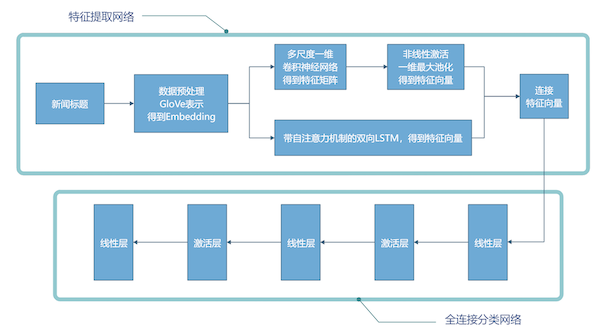


## 1.模型配置类：Config
包括模型各项必要的配置，用于存储学习率、双向LSTM的隐藏层数量等超参数，并记录数据集位置、代码运行时间等。

In [ ]:
class Config:
    def __init__(self):
        self.start_time = time.time()         # 记录代码开始运行的时间
        
        self.epoch_num=40                     # 训练的轮次数量
        self.lr=1e-2                          # 优化器的学习率
        self.momentum=0.9                     # SGD优化器的momentum参数
        self.weight_decay=1e-4                # SGD优化器的weight_decay参数
        self.batch_size=128                   # 一个批次数据包含的样本数
        self.kernel_size_list=[2, 3, 4, 5, 6] # 多尺度卷积层的卷积核宽度列表
        self.filter_num=50                    # 卷积层输出的通道数（单尺度卷积核）
        self.num_layer=1                      # 双向LSTM的隐藏层数量
        self.word_vec_dim = 300               # 预训练的词嵌入向量维度
        
        # 预训练词嵌入模型存放路径
        self.word_embedding_path = './GloVe/glove.6B.300d.txt'
        # 训练集和测试集数据存放路径
        self.training_data_root = './archive/Sarcasm_Headlines_Dataset.json'
        # 选择使用的设备，当存在cuda处理器时优先使用cuda，否则使用cpu
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def get_training_info(self):
        training_info = []
        for key in self.__dict__:
            if key == 'start_time':
                continue
            info = key + ' : ' + str(self.__dict__[key])
            training_info.append(info)
        return training_info


## 2.数据预处理类：DataManager
本数据预处理类能够完成搭建数据集前的全部数据预处理过程。处理流程为：
- 载入预训练的词嵌入表示模型（字典格式），见函数`load_word_embedding_model`；
- 载入全部训练数据，对标题字符串进行清洗（函数`clean_str`）、词元化、计算句子长度，并将句子（词元列表）、类别标识、句子长度均以列表形式保存,见函数`load_training_data`；
- 对训练数据中的全部语料信息进行统计，筛选出出现频率较高的一批词元，构建训练集词典，格式为{词元：索引值}，索引值0保留给<pad>，故此处索引从1开始，见函数`build_dict`；
- 根据训练集词典构建词嵌入表示矩阵（函数`build_word_embedding`）：在第1步得到的词嵌入表示模型字典中逐个检索第3步中训练集词典中的词元，若词元存在于模型字典中，则将对应向量插入词嵌入表示矩阵的对应行，否则用（-1，1）区间内均匀分布随机初始化该行向量。矩阵的第0行为全0行；
- 查询第3步中的训练集词典，将句子由词元列表形式转化成索引列表形式，以便直接输入模型的Embedding层，见函数`get_sentences`。

In [ ]:
class DataManager:
    def __init__(self, config):
        self.sentences = None         # 嵌套列表，列表中每个元素是一个句子，每个句子是一个词元列表
        self.lengths = None           # 句子长度列表
        self.labels = None            # 类别标识列表

        self.embedding_model = None               # 完整的预训练词嵌入表示模型（字典格式）
        self.dictionary = None                    # 训练集词典
        self.word_embedding = None                # 构建的词嵌入表示矩阵
        self.word_vec_dim = config.word_vec_dim   # 词向量维度

        self.config = config

        self.load_word_embedding_model()
        self.load_training_data()
        self.build_dict()
        self.build_word_embedding()
        print('Data loading completed.')
        print('==================================================')

        del self.embedding_model

    def get_sentences(self):
        """
            将句子由词元列表形式转化成索引列表形式，并将结果进行补齐。
        """
        sentence_list = []
        for i, sentence in enumerate(self.sentences):
            embedded_sentence = []
            for word in sentence:
                if word in self.dictionary.keys():
                    embedded_sentence.append(self.dictionary[word])
                else:
                    embedded_sentence.append(1)
            sentence_list.append(torch.tensor(embedded_sentence))
        sentence_list = pad_sequence(sentence_list, batch_first=True)
        return sentence_list

    def get_lengths(self):
        """
            返回张量格式的句子长度列表。
        """
        return torch.tensor(self.lengths)

    def get_labels(self):
        """
            返回张量格式的类别表示列表。
        """
        return torch.tensor(self.labels)

    def get_word_embedding(self):
        """
            返回张量格式的词嵌入表示矩阵。
        """
        return torch.tensor(self.word_embedding)

    @staticmethod
    def clean_str(text):
        """
            对字符串进行清洗。
        """
        text = text.lower()
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"that's", "that is ", text)
        text = re.sub(r"there's", "there is ", text)
        text = re.sub(r"it's", "it is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"\-", " - ", text)
        text = re.sub(r"\=", " = ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" u s ", " american ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"j k", "jk", text)
        text = re.sub(r"\s{2,}", " ", text)

        return text.strip()

    def load_word_embedding_model(self):
        """
            载入预训练的词嵌入表示模型。
        """
        start = time.time()
        vocab = {}
        with open(self.config.word_embedding_path, 'r', encoding='utf-8') as f:
            for _ in tqdm(range(400000), desc='Loading pretrained word embedding'):
                line = f.readline().strip().split()
                word = line[0].lower()
                vector = list(map(float, line[1:]))
                vocab[word] = vector
        end = time.time()
        print('Pretrained word embedding model has been loaded from:')
        print('   ', self.config.word_embedding_path)
        print('    Time consumed:', round(end - start, 2), 's')
        print('==================================================')
        time.sleep(0.01)
        self.embedding_model = vocab

    def load_training_data(self):
        """
            加载训练数据。
        """
        lines = [line for line in open(self.config.training_data_root, 'r')]
        labels = []
        headlines = []
        for line in lines:  # 按json格式处理每行数据，分别取出句子和类别标识，加到对应的列表中
            anno = json.loads(line)
            labels.append(anno['is_sarcastic'])
            headlines.append(anno['headline'])

        max_sen_len = 0

        sentences = []
        lengths = []
        for headline in headlines:
            headline = self.clean_str(headline)     # 清洗句子
            tokens = nltk.word_tokenize(headline)   # 词元化
            sentences.append(tokens)
            lengths.append(len(tokens))

            if len(tokens) > max_sen_len:
                max_sen_len = len(tokens)

        print('Training data has been loaded. ')
        print('    Max sentence length:', max_sen_len)

        self.sentences = sentences
        self.labels = labels
        self.lengths = lengths
        self.config.max_sen_len = max_sen_len

    def build_dict(self):
        """
            搭建训练数据词典。
        """
        word_counter = Counter()
        for sentence in self.sentences:
            for word in sentence:
                word_counter[word] += 1
        ls = word_counter.most_common()

        self.dictionary = {w[0]: index + 1 for (index, w) in enumerate(ls)}  # 索引值0保留给<pad>
        print('Dictionary building completed.')

    def build_word_embedding(self):
        """
            搭建词嵌入表示矩阵。
        """
        word_embedding = np.random.uniform(-1.0, 1.0, size=(len(self.dictionary) + 1, self.word_vec_dim))
        word_embedding[0] = np.zeros(self.word_vec_dim, dtype=float)
        for word in self.embedding_model.keys():
            if word in self.dictionary:
                word_embedding[self.dictionary[word]] = self.embedding_model[word]
        self.word_embedding = word_embedding.astype(np.float32)
        print('Word embedding building completed.')

## 3.数据集类：DataSet
继承DataSet类，实现数据读取流程的自定义。其中，对数据集进行了划分，设置前20000条数据为训练集，其余为测试集。

In [ ]:
class DataSet(Dataset):
    def __init__(self, datamanager, mode):
        sentences = datamanager.get_sentences()
        lengths = datamanager.get_lengths()
        labels = datamanager.get_labels()
        if mode == 'train':     # 训练集
            self.sentences = sentences[:20000]
            self.lengths = lengths[:20000]
            self.labels = labels[:20000]
        else:                  # 测试集
            self.sentences = sentences[20000:]
            self.lengths = lengths[20000:]
            self.labels = labels[20000:]

    def __getitem__(self, item):
        return self.sentences[item], self.lengths[item], self.labels[item]

    def __len__(self):
        return len(self.sentences)

## 4.模型主体：Model
详细结构见`0.模型结构`，该部分对各项操作进行了实现，各函数的功能如下：
- `__init__`：模型框架，包括词嵌入表示层、多尺度一维卷积层、双向LSTM层和全连接层。
- `forward`：实现前向传播，其中包含自注意力机制的双向LSTM层的前向传播在`lstm_layer`中实现
- `step`：实现一个批次数据的训练。
- `evaluate`：实现一个批次数据的测试。

In [ ]:
class Model(nn.Module):
    def __init__(self, config, datamanager):
        super(Model, self).__init__()
        self.config = config
        # 词嵌入表示层，用构建的词嵌入表示矩阵初始化，索引0设为<pad>，不参与反向传播求梯度的过程
        self.word_embedding = nn.Embedding.from_pretrained(
            embeddings=datamanager.get_word_embedding(),
            freeze=False,
            padding_idx=0
        )
        # 多尺度一维卷积层，每个分支包含一维卷积、双曲正切函数激活、沿句子长度方向的一维最大池化
        self.conv = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(
                    in_channels=config.word_vec_dim,
                    out_channels=config.filter_num,
                    kernel_size=kernel_size,
                    bias=True
                ),
                nn.Tanh(),
                nn.MaxPool1d(kernel_size=config.max_sen_len - kernel_size + 1)
            )
            for kernel_size in config.kernel_size_list
        ])
        # 双向LSTM，输入数据的第一维是batch维，与预处理过程中pad_sequence函数对应
        self.lstm = nn.LSTM(
            input_size=config.word_vec_dim,
            hidden_size=config.word_vec_dim,
            num_layers=config.num_layer,
            batch_first=True,
            bidirectional=True
        )
        # 双向LSTM注意力机制的权重张量
        self.w = nn.Parameter(torch.randn(config.word_vec_dim))
        # 全连接层（分类器）
        self.fc = nn.Sequential(
            nn.Linear(
                in_features=len(config.kernel_size_list) * config.filter_num + config.word_vec_dim,
                out_features=128
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=128,
                out_features=16
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=16,
                out_features=2
            )
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(
            params=self.parameters(),
            lr=config.lr,
            momentum=config.momentum,
            weight_decay=config.weight_decay
        )

    def lstm_layer(self, x, lengths):
        """
            包含自注意力机制的双向LSTM层的前向传播。
        """
        batch_size = x.size()[0]
        # 将经过长度补齐的句子压缩（去除pad部分）后送入LSTM
        x = pack_padded_sequence(
            input=x,
            lengths=lengths,
            batch_first=True,
            enforce_sorted=False
        )
        h, (_, _) = self.lstm(x)
        # 将LSTM的输出解压缩（恢复pad部分）
        h, _ = pad_packed_sequence(
            sequence=h,
            batch_first=True,
            total_length=self.config.max_sen_len
        )
        # 将双向LSTM两个方向的输出对应元素相加
        h = h.view(-1, self.config.max_sen_len, 2, self.config.word_vec_dim)
        h = torch.sum(h, dim=2)

        m = torch.tanh(h)
        
        # 双向LSTM输出的自注意力机制
        alpha = F.softmax(torch.bmm(m, self.w.repeat(batch_size, 1, 1).transpose(1, 2)), dim=0)
        r = torch.bmm(alpha.transpose(1, 2), h)
        h_star = torch.tanh(r)
        h_star = h_star.permute(0, 2, 1)
        return h_star

    def forward(self, sentences, lengths):
        x = self.word_embedding(sentences)

        conv_out = [conv(x.permute(0, 2, 1)) for conv in self.conv]
        lstm_out = self.lstm_layer(x, lengths)

        out = conv_out
        out.append(lstm_out)
        out = torch.cat(out, dim=1)     # 将所有卷积分支和双向LSTM分支的输出合并成一个向量，作为句子最终的特征向量
        out = out.view(-1, out.size(1))

        out = self.fc(out)

        return out

    def step(self, data):
        """
            一个批次数据的训练过程，包含前向传播、损失值计算、反向传播、更新参数、梯度归零。
        """
        scores = self.forward(data[0], data[1])
        loss = self.loss(scores, data[2])
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.data.tolist()

    @torch.no_grad()
    def evaluate(self, data):
        """
            一个批次数据的测试过程，返回该批次数据中的正确预测数和预测总数。
        """
        scores = self.forward(data[0], data[1])
        predicted_result = torch.argmax(scores, dim=-1)
        gt_result = data[2]
        correct_num = torch.sum(predicted_result == gt_result)
        return correct_num.data.tolist(), len(predicted_result)

## 5.神经网络训练工具类：Trainer
实现了网络的训练与测试，保存了训练日志，并将全过程准确率、损失函数的变化可视化。其中，各函数的功能如下：
- `train`：训练主函数，包含训练集和测试集上准确率的计算。
- `test`：测试主函数，包含准确率计算和保存。
- `save_training_log`：保存训练日志。
- `visualize`：将训练全程训练集准确率、测试集准确率、损失值可视化。

In [ ]:
class Trainer:
    def __init__(self, config, network, datamanager):
        # 用时信息
        self.start_time = config.start_time   # 获取程序开始时间
        self.end_time = None                  # 定义程序结束时间
        
        self.network = network.to(config.device)                  # 将神经网络转移到相应设备上
        self.train_dataset = DataSet(datamanager, mode='train')   # 构建训练集Dataset
        self.test_dataset = DataSet(datamanager, mode='test')     # 构建测试集Dataset
        self.train_dataloader = DataLoader(                       # 构建训练集Dataloader
            dataset=self.train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=2
        )
        self.test_dataloader = DataLoader(                        # 构建测试集Dataloader
            dataset=self.test_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=2
        )
        self.config = config
        
        self.train_acc_list = []    # 记录训练全程训练集准确率
        self.test_acc_list = []     # 记录训练全程测试集准确率
        self.loss_list = []         # 记录训练全程损失值

    def train(self):
        """
            训练主函数，包含训练集和测试集上准确率的计算。
        """
        print('Epoc\tTrain\tTest\tLoss')

        for i in range(self.config.epoch_num):
            loss = 0
            for j, data in enumerate(self.train_dataloader):
                data[0] = data[0].to(self.config.device)
                data[2] = data[2].to(self.config.device)
                loss += self.network.step(data)
                print('\rEpoch', i + 1, 'completed:', round(j * 100 / len(self.train_dataloader)), '%', end='')
                
            loss = loss / len(self.train_dataloader)    # 计算当前epoch中每个batch的平均损失值
            self.loss_list.append(loss)

            acc_info = '\r{:<8d}'.format(i + 1)
            train_acc = self.test(mode='train')
            acc_info += '{:<8.1f}'.format(train_acc * 100)
            test_acc = self.test(mode='test')
            acc_info += '{:<8.1f}'.format(test_acc * 100)
            acc_info += '{:<8.5f}'.format(loss)
            print(acc_info + '                                       ')
        self.end_time = time.time()
        print('==================================================')
        print('Time consumed:', round(self.end_time - self.start_time, 1), 's')

    def test(self, mode):
        """
            测试主函数，包含准确率计算和保存。
        """
        self.network.eval()
        if mode == 'train':
            dataloader = self.train_dataloader
        else:
            dataloader = self.test_dataloader

        correct_num = 0
        predicted_num = 0
        length = len(dataloader)
        for i, data in enumerate(dataloader):
            data[0] = data[0].to(self.config.device)
            data[2] = data[2].to(self.config.device)
            c, p = self.network.evaluate(data)
            correct_num += c
            predicted_num += p
            if mode == 'train':
                info = 'Calculating accuracy on training set: ' + str(round(100 * i / length)) + ' %'
            else:
                info = 'Calculating accuracy on testing set:' + str(round(100 * i / length)) + ' %'
            print('\r' + info + '        ', end='')
        acc = correct_num / predicted_num

        if mode == 'train':
            self.train_acc_list.append(acc)
        else:
            self.test_acc_list.append(acc)
        self.network.train()
        return acc

    def save_training_log(self):
        """
            保存训练日志。
        """
        model = self.network.__class__.__name__
        t = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = model + '_' + t + '_.txt'
        path = './TrainingLog/' + filename
        file = open(path, 'w')
        training_info = self.config.get_training_info()
        for info in training_info:
            file.write(info + '\n')
        file.write('==============================\n')
        file.write('Epoc    Train   Test    Loss\n')
        for i in range(self.config.epoch_num):
            line = '{:<8d}'.format(i + 1) + '{:<8.1f}'.format(self.train_acc_list[i] * 100) + \
                   '{:<8.1f}'.format(self.test_acc_list[i] * 100) + '{:<8.1f}'.format(self.loss_list[i] * 100) + '\n'
            file.write(line)
        file.write('==============================\n')
        best_acc = np.max(self.test_acc_list)
        line = 'Best accuracy: ' + str(round(best_acc * 100, 1)) + '%\n'
        file.write(line)
        line = 'Time consumed: ' + str(round(self.end_time - self.start_time, 1)) + 's\n'
        file.write(line)
        file.close()

    def visualize(self):
        """
            将训练全程训练集准确率、测试集准确率、损失值可视化。
        """
        model = self.network.__class__.__name__
        t = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        acc_path = './Figure/' + model + '_' + t + '_acc.jpg'
        loss_path = './Figure/' + model + '_' + t + '_loss.jpg'

        x = np.array(range(1, self.config.epoch_num + 1))
        y1 = np.array(self.train_acc_list)
        y2 = np.array(self.test_acc_list)
        y3 = np.array(self.loss_list)
        y1 = y1 * 100
        y2 = y2 * 100

        plt.figure()
        plt.xlabel('Epoch', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.ylabel('Accuracy/%', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.plot(x, y1, 'dodgerblue', linewidth=1.0, label='Train')
        plt.plot(x, y2, 'red', linewidth=1.0, label='Test')
        plt.xticks(fontproperties='Times New Roman', size=10)
        plt.yticks(fontproperties='Times New Roman', size=10)
        plt.legend(prop={'family': 'Times New Roman', 'size': 10})
        plt.savefig(acc_path)
        plt.show()

        plt.figure()
        plt.xlabel('Epoch', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.ylabel('Loss', fontdict={'family': 'Times New Roman', 'size': 14})
        plt.plot(x, y3, 'red', linewidth=1.0)
        plt.xticks(fontproperties='Times New Roman', size=10)
        plt.yticks(fontproperties='Times New Roman', size=10)
        plt.legend(prop={'family': 'Times New Roman', 'size': 10})
        plt.savefig(loss_path)
        plt.show()

## 6.模型训练、测试与结果的可视化

In [ ]:
config = Config()
datamanager = DataManager(config)
model = Model(config, datamanager)
trainer = Trainer(config, model, datamanager)
trainer.train()
trainer.save_training_log()
trainer.visualize()